# Imports

In [1]:
#%% imports
import glob
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
from tqdm.auto import tqdm

sys.path.append('..')
import fstlib
import medicc

sys.path.append('../Figures_Kaufmann_et_al_2021')
from plotting_params import plotting_params, set_plotting_params

set_plotting_params()

In [2]:
%matplotlib inline

# Load data

REQUIRED FILES TO RUN THIS:

set variable `pcawg_folder` as desired and set `LOAD = False`

Save and unpack as data_folder
From https://dcc.icgc.org/releases/PCAWG/consensus_cnv/
* consensus.20170119.somatic.cna.annotated.tar.gz

Place in metadata_folder:
From https://dcc.icgc.org/releases/PCAWG/clinical_and_histology/
* pcawg_specimen_histology_August2016_v9.xlsx
* pcawg_donor_clinical_August2016_v9.xlsx

From https://dcc.icgc.org/releases/PCAWG/terminology_and_standard_colours
* pcawg-glossary-colour-references.xlsx

From https://dcc.icgc.org/releases/PCAWG/data_releases/latest/

* pcawg_sample_sheet.tsv
https://github.com/PCAWG-11/Heterogeneity/raw/master/code_figures_paper/figure_1b/wgd.status.txt.gz

In [3]:
LOAD = True

#%% FSTs
T_wgd_asymm = medicc.io.read_fst()
T_no_wgd_asymm = medicc.io.read_fst(no_wgd=True)
T_1_wgd_asymm = medicc.io.read_fst(n_wgd=1)
symbol_table = T_wgd_asymm.input_symbols()

#%% folders and HDF5 store
# modify this to point to your local PCAWG folder
pcawg_folder = '../../data/PCAWG'
data_folder = os.path.join(pcawg_folder, 'consensus.20170119.somatic.cna.annotated')
metadata_folder = os.path.join(pcawg_folder, 'metadata')
figures_folder = '../Figures_Kaufmann_et_al_2021/data/'

#%% open HDF5 store
hdfstore = pd.HDFStore(os.path.join(pcawg_folder, 'pcawg_scna.hdf5'))

# Run

## Metadata

In [4]:
if LOAD:
    meta = hdfstore['metadata/simple']
    tumour_types = hdfstore['metadata/tumour_types']
else:
    ## sample master table
    pmd_samples = pd.read_csv(os.path.join(metadata_folder, 'pcawg_sample_sheet.tsv'), sep='\t')
    pmd_samples.set_index('aliquot_id', inplace=True)
    pmd_samples.sort_index(inplace=True)
    specimen_details = pmd_samples.dcc_specimen_type.str.split("-", expand=True)
    specimen_details.columns = ["dcc_specimen_type1", "dcc_specimen_type2"]
    specimen_details['dcc_specimen_type1'] = specimen_details['dcc_specimen_type1'].str.strip()
    specimen_details['dcc_specimen_type2'] = specimen_details['dcc_specimen_type2'].str.strip()
    pmd_samples = pmd_samples.join(specimen_details)

    ## histology table
    pmd_histology = pd.read_excel(os.path.join(
        metadata_folder, 'pcawg_specimen_histology_August2016_v9.xlsx'), dtype='str')
    pmd_histology['percentage_cellularity'] = pmd_histology['percentage_cellularity'].astype(
        'float')
    pmd_histology.set_index('icgc_sample_id', inplace=True)
    pmd_histology.sort_index(inplace=True)
    pmd_histology = pmd_histology.drop(
        pmd_histology.columns[pmd_histology.columns.str.startswith('Unnamed')], axis=1)

    ## clinical table
    pmd_clinical = pd.read_excel(os.path.join(
        metadata_folder, 'pcawg_donor_clinical_August2016_v9.xlsx'), dtype='str')
    pmd_clinical = pmd_clinical.drop(
        pmd_clinical.columns[pmd_clinical.columns.str.startswith('Unnamed')], axis=1)
    pmd_clinical.columns = pmd_clinical.columns.str.replace('#', '').str.strip()
    pmd_clinical.set_index('donor_unique_id', inplace=True)
    pmd_clinical.sort_index(inplace=True)

    ## purity / ploidy table from consensus SCNA callset
    pmd_purity = pd.read_csv(os.path.join(
        metadata_folder, 'consensus.20170217.purity.ploidy.txt'), sep='\t')
    pmd_purity.rename({'samplename': 'aliquot_id'}, inplace=True, axis=1)
    pmd_purity.set_index('aliquot_id', inplace=True)

    ## glossary (needs fixing...)
    pmd_glossary = pd.read_excel(os.path.join(
        metadata_folder, 'pcawg-glossary-colour-references.xlsx'), dtype='str', sheet_name='Glossary')
    pmd_glossary = pmd_glossary.drop(
        pmd_glossary.columns[pmd_glossary.columns.str.startswith('Unnamed')], axis=1)
    pmd_glossary['Term'] = pmd_glossary['Term'].str.replace('Aeno', 'Adeno')
    pmd_glossary['Term'] = pmd_glossary['Term'].str.replace('Bladder', 'Bladder-TCC')
    pmd_glossary['Term'] = pmd_glossary['Term'].str.replace('Bone-Leiomyo', 'SoftTissue-Leiomyo')
    pmd_glossary['Term'] = pmd_glossary['Term'].str.replace('Bone-Cart', 'Bone-Benign')
    pmd_glossary.loc[pmd_glossary.shape[0], :] = ['Tumour Subtype',
                                                  'SoftTissue-Liposarc', '-', 'SoftTissue-Liposarc', '?']

    ## colors
    pmd_colors = pd.read_excel(os.path.join(metadata_folder, 'pcawg-glossary-colour-references.xlsx'),
                               dtype='str', sheet_name='ColourReferenceTable_2017-08-23')
    pmd_colors = pmd_colors.drop(
        pmd_colors.columns[pmd_colors.columns.str.startswith('Unnamed')], axis=1)
    pmd_colors['Scheme'] = pmd_colors['Scheme'].fillna(method='ffill')
    pmd_colors = pmd_colors.loc[~pmd_colors.iloc[:, 1:].isnull().all(axis=1), :]
    pmd_colors['Term'] = pmd_colors['Term'].str.replace('Bone-Cart', 'Bone-Benign')

    ## extract tumour types from glossary and colors
    tumour_types = pmd_glossary.query("Context=='Tumour Subtype'")[['Term', 'Definition']]
    tumour_types.set_index('Term', inplace=True)
    tumour_types = tumour_types.join(pmd_colors.query(
        "Scheme=='Tumour.Subtype' or Scheme=='Low Sample Size Cohorts'").drop('Scheme', axis=1).set_index('Term'))
    tumour_types.index.name = 'histology_abbreviation'
    tumour_types.sort_index(inplace=True)
    tumour_types['histology_useable'] = True
    tumour_types['histology_useable'] = tumour_types['histology_useable'].astype('bool')
    tumour_types.loc['Bone-Benign', 'histology_useable'] = False
    tumour_types.loc['Breast-LobularCA', 'histology_useable'] = False
    tumour_types.loc['Breast-DCIS', 'histology_useable'] = False
    tumour_types.loc['Lymph-NOS', 'histology_useable'] = False
    tumour_types.loc['Myeloid-MDS', 'histology_useable'] = False
    tumour_types.loc['Cervix-AdenoCA', 'histology_useable'] = False

    meta = pmd_samples[['icgc_sample_id', 'donor_unique_id',
                        'library_strategy', 'dcc_specimen_type1', 'dcc_specimen_type2']]
    meta = meta.merge(pmd_histology[['histology_abbreviation', 'histology_tier1', 'histology_tier2', 'histology_tier3',
                                     'histology_tier4', 'percentage_cellularity']], left_on='icgc_sample_id', right_index=True, how='inner')
    meta = meta.loc[~meta.histology_abbreviation.isnull(), :]
    meta = meta.merge(tumour_types, left_on='histology_abbreviation', right_index=True, how='left')
    meta.rename({'Definition': 'histology_full_name'}, inplace=True, axis=1)
    meta = meta.merge(pmd_clinical, how='left', left_on='donor_unique_id', right_index=True)
    meta = meta.join(pmd_purity)
    meta['wgd_uncertain'] = meta['wgd_uncertain'].astype('bool')

    hdfstore.put('metadata/samples', pmd_samples, format='table')
    hdfstore.put('metadata/histology', pmd_histology, format='table')
    hdfstore.put('metadata/clinical', pmd_clinical, format='table')
    hdfstore.put('metadata/purity', pmd_purity, format='table')
    hdfstore.put('metadata/colors', pmd_colors, format='table')
    hdfstore.put('metadata/tumour_types', tumour_types, format='table')
    hdfstore.put('metadata/simple', meta, format='table')


## WGD (PCAWG)

In [5]:
# Ploidy data from the PCAWG publication
# Characterizing genetic intra-tumor heterogeneity across 2,658 human cancer genomes
# https://doi.org/10.1016/j.cell.2021.03.009
if LOAD:
    wgd = hdfstore['wgd']
else:
    wgd = pd.read_csv(os.path.join(metadata_folder, 'wgd.status.txt'), sep='\t')
    wgd.rename({'samplename': 'sample_id', 'ploidy': 'ploidy_pcawg'}, inplace=True, axis=1)
    wgd.set_index('sample_id', inplace=True)

    hdfstore.put('wgd', wgd, format='table')


## Load and phase CNPs

In [6]:
if LOAD:
    dat = hdfstore['scna']
else:
    ## load CNPs
    files = glob.glob(data_folder + '/*.txt')
    index = []
    data = []
    for f in files:
        pid = os.path.basename(f).split('.')[0]
        try:
            df = pd.read_csv(f, sep='\t')
            df['end'] = df['end'].astype('int64')  # some pcawg 'end' values are floating point
            df.set_index(['chromosome', 'start', 'end'], inplace=True)
            index.append(pid)
            data.append(df)
        except ValueError:
            print(f)

    dat = pd.concat(data, keys=index, names=['sample_id', 'chrom', 'start', 'end'])
    dat = dat[['major_cn', 'minor_cn']]
    dat = dat.loc[~dat.isnull().any(axis=1), :]
    dat['major_cn'] = np.fmin(dat['major_cn'], 8)
    dat['minor_cn'] = np.fmin(dat['minor_cn'], 8)
    dat['major_cn'] = dat['major_cn'].astype('int').astype('str')
    dat['minor_cn'] = dat['minor_cn'].astype('int').astype('str')

    # Create diploid FSA
    diploid_fsa = fstlib.Fst()
    diploid_fsa.set_input_symbols(symbol_table)
    diploid_fsa.set_output_symbols(T_wgd_asymm.output_symbols())
    diploid_fsa.add_state()
    diploid_fsa.set_start(0)
    diploid_fsa.set_final(0, 0)
    diploid_fsa.add_arc(0, ('1', '1', 0, 0))
    diploid_fsa.add_arc(0, ('X', 'X', 0, 0))

    dat = dat.query("chrom != 'X' and chrom != 'Y'")  # filter X/Y chromosomes

    phasing_scores = {}
    phased_dfs = []
    for idx, df in dat.groupby('sample_id'):
        phasing_dict = medicc.create_phasing_fsa_dict_from_df(df, symbol_table, 'X')
        fsa_dict_a, fsa_dict_b, scores = medicc.phase_dict(phasing_dict, T_wgd_asymm, diploid_fsa)
        phased = medicc.core.create_df_from_phasing_fsa(df, [fsa_dict_a, fsa_dict_b], 'X')
        phased.columns = ['cn_a', 'cn_b']
        phased_dfs.append(phased)
        phasing_scores.update(scores)

    phasing_scores = pd.Series(phasing_scores, name='dist_to_diploid')
    phased_df = pd.concat(phased_dfs)

    dat = dat.join(phased_df, how='left')

    ## store CNPs
    hdfstore.put('scna', dat, format='table')


## determine no_wgd distances

In [7]:
if LOAD:
    distances = hdfstore['distances']
else:
    # Create diploid FSA
    diploid_fsa = fstlib.Fst()
    diploid_fsa.set_input_symbols(symbol_table)
    diploid_fsa.set_output_symbols(T_wgd_asymm.output_symbols())
    diploid_fsa.add_state()
    diploid_fsa.set_start(0)
    diploid_fsa.set_final(0, 0)
    diploid_fsa.add_arc(0, ('1', '1', 0, 0))
    diploid_fsa.add_arc(0, ('X', 'X', 0, 0))

    # Calc distance without WGD
    fsa_dict = medicc.create_standard_fsa_dict_from_data(dat[['cn_a', 'cn_b']], symbol_table, 'X')
    dist_no_wgd = pd.Series({aliquot_id: float(fstlib.score(T_no_wgd_asymm, diploid_fsa, fsa))
                             for aliquot_id, fsa in fsa_dict.items()}, name='dist_no_wgd_a')
    dist_no_wgd.name = 'dist_no_wgd'

    # Calc distance with WGD
    dist_wgd = pd.Series({aliquot_id: float(fstlib.score(T_wgd_asymm, diploid_fsa, fsa))
                          for aliquot_id, fsa in fsa_dict.items()}, name='dist_wgd_a')
    dist_wgd.name = 'dist_wgd'

    # Calc distance with only a single WGD
    dist_1_wgd = pd.Series({aliquot_id: float(fstlib.score(T_1_wgd_asymm, diploid_fsa, fsa))
                          for aliquot_id, fsa in fsa_dict.items()}, name='dist_wgd_a')
    dist_1_wgd.name = 'dist_1_wgd'

    distances = pd.concat([dist_no_wgd, dist_wgd, dist_1_wgd], axis=1)
    distances['dist_diff'] = distances['dist_no_wgd'] - distances['dist_wgd']
    distances['dist_diff_1_wgd'] = distances['dist_wgd'] - distances['dist_1_wgd']

    hdfstore.put('distances', distances, format='table')

## Bootstrap for WGD detection

In [8]:
# This cell will take some time to finish
# if LOAD:
if LOAD:
    bootstrap_results = hdfstore['bootstrap_distances']
else:
    N_bootstrap = 100
    samples = np.unique(dat.index.get_level_values('sample_id'))

    # Create diploid FSA
    diploid_fsa = fstlib.Fst()
    diploid_fsa.set_input_symbols(symbol_table)
    diploid_fsa.set_output_symbols(T_wgd_asymm.output_symbols())
    diploid_fsa.add_state()
    diploid_fsa.set_start(0)
    diploid_fsa.set_final(0, 0)
    diploid_fsa.add_arc(0, ('1', '1', 0, 0))
    diploid_fsa.add_arc(0, ('X', 'X', 0, 0))

    bootstrap_distances = -1*np.ones((len(samples), 3, N_bootstrap))

    for i in tqdm(np.arange(N_bootstrap)):
        bootstrap_dat = medicc.bootstrap.chr_wise_bootstrap_df(dat)

        FSA_dict = medicc.create_standard_fsa_dict_from_data(
            bootstrap_dat, symbol_table, 'X')
        dist_no_wgd = pd.Series({aliquot_id: float(fstlib.score(T_no_wgd_asymm, diploid_fsa, fsa))
                                 for aliquot_id, fsa in FSA_dict.items()}, name='dist_no_wgd')
        dist_wgd = pd.Series({aliquot_id: float(fstlib.score(T_wgd_asymm, diploid_fsa, fsa))
                              for aliquot_id, fsa in FSA_dict.items()}, name='dist_wgd')
        dist_1_wgd = pd.Series({aliquot_id: float(fstlib.score(T_1_wgd_asymm, diploid_fsa, fsa))
                              for aliquot_id, fsa in FSA_dict.items()}, name='dist_1_wgd')

        bootstrap_distances[:, 0, i] = dist_wgd
        bootstrap_distances[:, 1, i] = dist_no_wgd
        bootstrap_distances[:, 2, i] = dist_1_wgd

    bootstrap_results = pd.DataFrame(index=samples)

    bootstrap_results['pcawg_wgd'] = meta.loc[samples, 'wgd_status']
    bootstrap_results['nr_bootstraps_with_wgd'] = N_bootstrap - \
        np.sum((bootstrap_distances[:, 1, :] - bootstrap_distances[:, 0, :]) == 0, axis=1)
    bootstrap_results['nr_bootstraps_with_2_wgds'] = N_bootstrap - \
        np.sum((bootstrap_distances[:, 0, :] - bootstrap_distances[:, 2, :]) == 0, axis=1)
    bootstrap_results['bootstrap_wgd'] = (
        bootstrap_results['nr_bootstraps_with_wgd'] / N_bootstrap) > 0.05
    bootstrap_results['bootstrap_2_wgds'] = (
        bootstrap_results['nr_bootstraps_with_2_wgds'] / N_bootstrap) > 0.05

    hdfstore.put('bootstrap_distances', bootstrap_results, format='table')

## Close hdfstore

In [9]:
hdfstore.close()

# Results

In [10]:
# result = distances.join(
#     wgd[['ploidy_pcawg', 'hom']]).join(bootstrap_results[['bootstrap_wgd', 'bootstrap_2_wgds']])
result = meta[['wgd_status', 'wgd_uncertain', 'histology_useable', 'histology_abbreviation']].join(distances, how='inner').join(
    wgd[['ploidy_pcawg', 'hom']]).join(bootstrap_results[['bootstrap_wgd', 'bootstrap_2_wgds', 'nr_bootstraps_with_wgd', 'nr_bootstraps_with_2_wgds']])
result['pcawg_wgd'] = result['wgd_status'].map({'wgd': 'WGD', 'no_wgd': 'No WGD'})
result['wgd_status_medicc'] = (result['dist_diff'] >= 1).map({True: 'WGD', False: 'No WGD'})
result['wgd_status_medicc_bootstrap'] = (result['bootstrap_wgd']).map({
    True: 'WGD', False: 'No WGD'})
linex = np.linspace(0, result.hom.max())
linea = -2
linec = 2.9
liney = linea * linex + linec

In [11]:
#%% Overlap with PCAWG labels
confusion_matrix = pd.crosstab(result['pcawg_wgd'], result['wgd_status_medicc'])

print(confusion_matrix)
confusion_matrix = confusion_matrix.astype(int)
print('Pure MEDICC2 results:\n{:.1f}% correct classification'.format(
    100*(confusion_matrix.iloc[0, 0] + confusion_matrix.iloc[1, 1]) / confusion_matrix.sum().sum()))

wgd_status_medicc  No WGD  WGD
pcawg_wgd                     
No WGD               1960    0
WGD                   110  708
Pure MEDICC2 results:
96.0% correct classification


In [12]:
#%% Overlap with PCAWG labels (with uncertain ones removed)
confusion_matrix = pd.crosstab(result.loc[~result['wgd_uncertain'], 'pcawg_wgd'], result.loc[~result['wgd_uncertain'], 'wgd_status_medicc'])

print(confusion_matrix)
confusion_matrix = confusion_matrix.astype(int)
print('Pure MEDICC2 results (uncertain ones removed):\n{:.1f}% correct classification'.format(
    100*(confusion_matrix.iloc[0, 0] + confusion_matrix.iloc[1, 1]) / confusion_matrix.sum().sum()))


wgd_status_medicc  No WGD  WGD
pcawg_wgd                     
No WGD               1899    0
WGD                    93  668
Pure MEDICC2 results (uncertain ones removed):
96.5% correct classification


In [13]:

#%% test for association with uncertainty
uncertain = pd.crosstab(result.eval(
    "pcawg_wgd != wgd_status_medicc"), result['wgd_uncertain'])
print(uncertain)
print("p-value for over-represenation of uncertain samples in false predictions: {:.1e}".format(
    sp.stats.chi2_contingency(uncertain)[1]))
# print(sp.stats.chi2_contingency(uncertain)[3])


wgd_uncertain  False  True
row_0                     
False           2567   101
True              93    17
p-value for over-represenation of uncertain samples in false predictions: 1.2e-08


In [14]:
#%% Overlap with PCAWG labels from Bootstrap
confusion_matrix_bootstrap = pd.crosstab(
    bootstrap_results['pcawg_wgd'], bootstrap_results['bootstrap_wgd'])
print(confusion_matrix_bootstrap)
confusion_matrix_bootstrap = confusion_matrix_bootstrap.astype(int)
print('MEDICC2 bootstrap results:\n{:.1f}% correct classification'.format(
    100*(confusion_matrix_bootstrap.iloc[0, 0] + confusion_matrix_bootstrap.iloc[1, 1]) / confusion_matrix_bootstrap.sum().sum()))


bootstrap_wgd  False  True
pcawg_wgd                 
no_wgd          1954     6
wgd               27   791
MEDICC2 bootstrap results:
98.8% correct classification


In [15]:
#%% Overlap with PCAWG labels from Bootstrap (with uncertain ones removed)
confusion_matrix_bootstrap = pd.crosstab(
    bootstrap_results.loc[~result['wgd_uncertain'], 'pcawg_wgd'], bootstrap_results.loc[~result['wgd_uncertain'], 'bootstrap_wgd'])
print(confusion_matrix_bootstrap)
confusion_matrix_bootstrap = confusion_matrix_bootstrap.astype(int)
print('MEDICC2 bootstrap results (when uncertain ones are removed):\n{:.1f}% correct classification'.format(
    100*(confusion_matrix_bootstrap.iloc[0, 0] + confusion_matrix_bootstrap.iloc[1, 1]) / confusion_matrix_bootstrap.sum().sum()))


bootstrap_wgd  False  True
pcawg_wgd                 
no_wgd          1896     3
wgd               23   738
MEDICC2 bootstrap results (when uncertain ones are removed):
99.0% correct classification


In [16]:
#%% test for association with uncertainty
uncertain = pd.crosstab(result.eval(
    "pcawg_wgd != wgd_status_medicc_bootstrap"), result['wgd_uncertain'])
print(uncertain)
print("Bootstrap: p-value for over-represenation of uncertain samples in false predictions: {:.1e}".format(
    sp.stats.chi2_contingency(uncertain)[1]))
# print(sp.stats.chi2_contingency(uncertain)[3])


wgd_uncertain  False  True
row_0                     
False           2634   111
True              26     7
Bootstrap: p-value for over-represenation of uncertain samples in false predictions: 9.6e-06


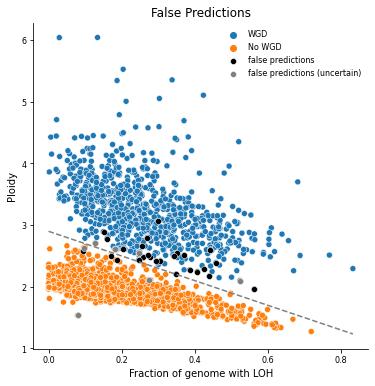

In [17]:
# %% Figure with false MEDICC predictions
fig, ax = plt.subplots(figsize=(plotting_params['WIDTH_HALF'], plotting_params['WIDTH_HALF']))
sns.scatterplot(x='hom', y='ploidy_pcawg', data=result, hue='pcawg_wgd', ax=ax)
sns.scatterplot(x='hom', y='ploidy_pcawg', data=result.loc[result.eval('pcawg_wgd != wgd_status_medicc_bootstrap')],
                color='black', label='false predictions')
sns.scatterplot(x='hom', y='ploidy_pcawg', data=result.loc[result.eval('pcawg_wgd != wgd_status_medicc_bootstrap') &
                                                           result['wgd_uncertain']],
                color='grey', label='false predictions (uncertain)')
ax.set_title('False Predictions')
ax.set_xlabel('Fraction of genome with LOH')
ax.set_ylabel('Ploidy')
ax.plot(linex, liney, '--', color='grey')


Text(0, 0.5, 'PCAWG histology')

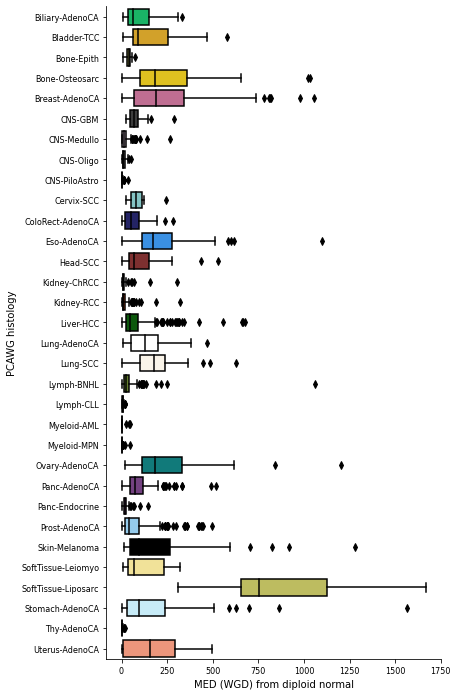

In [18]:
# %% plot PCAWG MED distributions
palette = dict(zip(tumour_types.index, tumour_types.Hexadecimal))
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(plotting_params['WIDTH_HALF'], plotting_params['WIDTH_FULL']))
plotdat = result.query("histology_useable").sort_values('histology_abbreviation')
sns.boxplot(x='dist_wgd', y='histology_abbreviation', palette=palette, data=plotdat, ax=ax)
ax.set_xlabel('MED (WGD) from diploid normal')
ax.set_ylabel('PCAWG histology')


Text(0, 0.5, 'PCAWG histology')

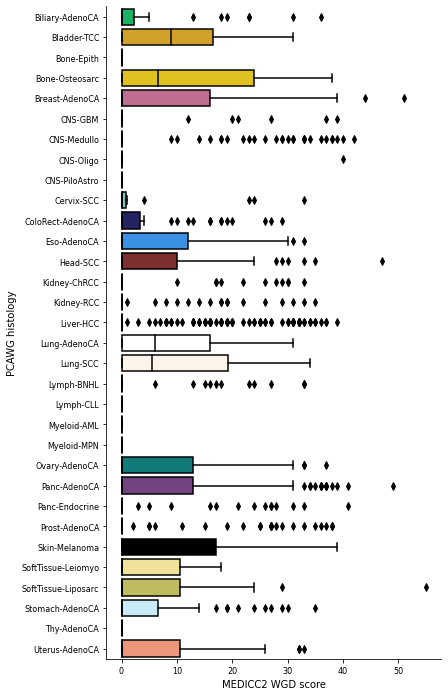

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(
    plotting_params['WIDTH_HALF'], plotting_params['WIDTH_FULL']))
plotdat = result.query("histology_useable").sort_values('histology_abbreviation')
sns.boxplot(x='dist_diff', y='histology_abbreviation', palette=palette, data=plotdat, ax=ax)
ax.set_xlabel('MEDICC2 WGD score')
ax.set_ylabel('PCAWG histology')



# Save for plotting

In [20]:
result[['hom', 'ploidy_pcawg', 'pcawg_wgd', 'histology_abbreviation', 'wgd_status_medicc_bootstrap',
        'bootstrap_2_wgds', 'histology_useable', 'dist_diff', 'dist_wgd',
        'wgd_uncertain', 'nr_bootstraps_with_wgd', 'nr_bootstraps_with_2_wgds']].to_csv(
            os.path.join(figures_folder, 'Fig_2D_and_Supp_10.tsv'),
    sep='\t', index=False)

tumour_types[['Hexadecimal']].to_csv(
    os.path.join(figures_folder, 'Supp_10_color_palette.tsv.tsv'),
    sep='\t', index=True)